*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

## Implement Locally Competitive Algorithms as Quadratic Programs

This tutorial covers how to use the Quadratic Program (QP) Solver developed in LAVA to implement Locally Competitive Algorithms (LCA) on Loihi.

### Recommended Tutorials before starting

- [Installing Lava](https://github.com/lava-nc/lava/blob/main/src/lava/tutorials/in_depth/tutorial01_installing_lava.ipynb)
- [Processes](https://github.com/lava-nc/lava/blob/main/src/lava/tutorials/in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](https://github.com/lava-nc/lava/blob/main/src/lava/tutorials/in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Execution](https://github.com/lava-nc/lava/blob/main/src/lava/tutorials/in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")

### A QP solver on Loihi

Due to fixed-point architecture, Loihi can not perform inversions and thus can only handle first-order iterative algorithms. Towards this,we use an update scheme that respects the limitations imposed by Loihi. The update scheme consists of two steps ,namely, Gradient descent and constraint-correction. The gradient descent evolves in the unconstrained space of the QP and the constraint-correction after the constraint-check ensures that the gradeint dynamics evolve in the feasible of the QP. <br>
Consider the following QP,
$$ \text{argmin} \frac{1}{2}x^TQx + p^Tx $$
$$ \text{s.t.  } Ax \le k,$$ 
where $ x \in \mathbb{R}^n$, $ Q \in \mathbb{S}_{+}^{n \times n}$, $ p \in \mathbb{R}^n$ , $ A \in \mathbb{R}^{m \times n} $ and $ k \in \mathbb{R}^m$ where $m$ and $n$ are integers. This can be solved with the following first-order iterative update scheme,

$$ x_{i+1} = -\alpha_i (Qx_i + p) - \beta_i A^T\delta_G(x_i)$$

$$ \delta_G(x_i) = \left\{\begin{array}{lr}
        Ax_i-k, & \text{for } Ax_i \leq k\\
            0, & \text{for } Ax_i \geq k\\
        \end{array}\right\},  $$

where $i$ is some integer, $\alpha_i$ is the learning rate and $\beta_i$ is the constraint-correction rate. $\delta_G$ is a "graded spike" which Loihi 2 supports. Note that equality constraints can be expressed as sandwiched inequality constraints. The process diagram for the solver in LAVA is shown below

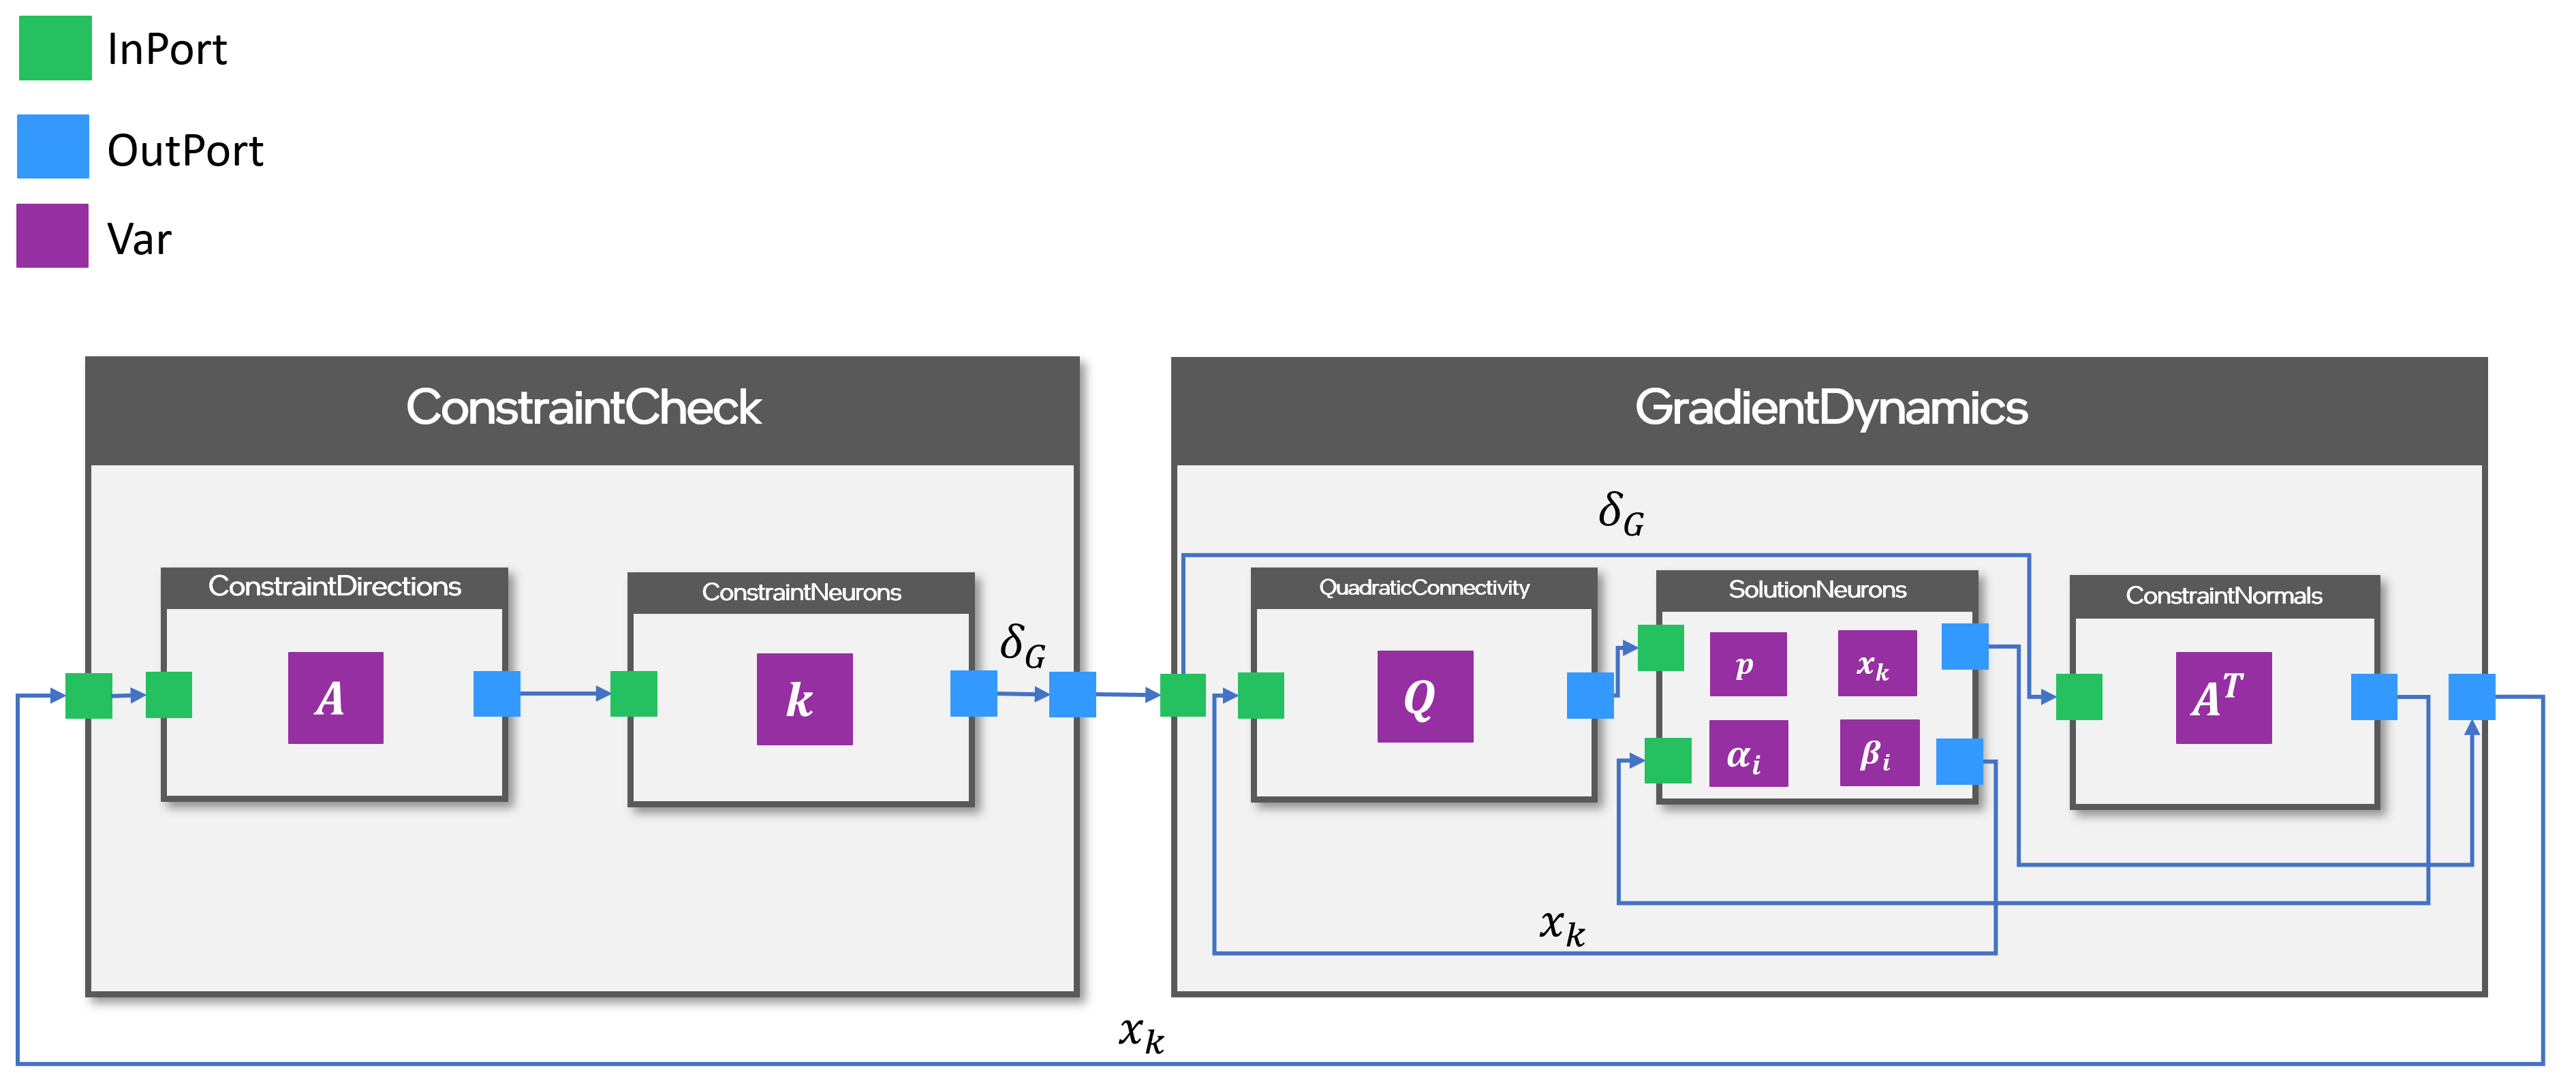

### The LASSO problem as an LCA

Consider the (Least Absolute Shrinkage and Selection Operation) LASSO problem,
$$ \text{argmin } \frac{1}{2}||Px - q||_2^2 $$
$$ \text{s.t.  } ||x||_1 \leq \tau,$$ 
where $ x \in \mathbb{R}^n$, $ P \in \mathbb{R}^{n \times n}$, $ q \in \mathbb{R}^n$ , where $\tau$ is some constant. It has been shown that the LCA dynamics in principle solve a LASSO problem. The LASSO problem can be rewritten as an exponential QP of the following form. 
$$ \text{argmin } \frac{1}{2}||Px - q||_2^2 $$
$$ \text{s.t.  } a_i^Tx_i \leq \tau, \forall i$$ 
where $a_i$ are all $2^n$ vectors of $+1$ or $-1$.

The exponential QP can be further expressed as:
$$ \text{argmin } \frac{1}{2}x^TQx + p^Tx$$
$$ \text{s.t.  } a_i^Tx_i \leq \tau, \forall i$$ 
where $Q = P^TP$ , $p= -P^Tq$. We ignore the constant term as it does not affect the solution of the QP.


### Using the Loihi QP solver to solve LASSO

In [1]:
# Import the QP solver and Problem classes
import numpy as np
from lava.lib.optimization.problems.problems import QP
from lava.lib.optimization.solvers.qp.solver import QPSolver

Consider the LASSO problem with 

In [2]:
P = np.array([[3, 1, 2], [10, 3, 2], [0, 0, 5]])
q = np.array([[1, 2, 1]]).T
tau = 10

We now rewrite the LASSO problem as a QP  and feed it to our solver. Note that the solver does some preconditioning before applying the first-order algorithm explained above. The parameters `alpha` and `beta` determine the speed of convergence to the solution. `alpha_d` and `beta_g` are the timesteps after which `alpha`/`beta` are decreased/increased via a right/left shift.

In [3]:
## setting up the LASSO problem
Q = P.T@P
p = -P.T@q
A = np.array([[-1, -1,  1], 
              [-1,  1, -1],
              [-1,  1,  1],
              [ 1, -1, -1],
              [ 1, -1,  1],
              [ 1,  1, -1],
              [ 1,  1,  1],
              [-1, -1, -1],
             ])
k = tau*np.ones((1,8)).T

## Learning constants for the solver
alpha, beta = 1, 1
alpha_d, beta_g = 10000, 10000

In [4]:
# Arguments to solver Q, p, A, k, A_eq, k_eq
problem = QP(Q, p, A, k)
solver = QPSolver(
    alpha=alpha,
    beta=beta,
    alpha_decay_schedule=alpha_d,
    beta_growth_schedule=beta_g,
    )
solver.solve(problem, iterations=1000)

[LavaQpOpt][INFO]: The solution after 1000 iterations is 
             [[0.09252278]
 [0.        ]
 [0.15291376]]

 [LavaQpOpt][INFO]: QP Solver ran in 98.68387174606323 seconds


Note that the actual solution to this problem is $(0.144, 0.05, 0.205)$ which is close to the solution obtained above given that the problem starts from a random intial value. The neuromorphic QP solver demonstrates convergent behavior. The accuracy drop is partly due to a bug in Lava which will be fixed soon. Further improvements to the tuning heuristics, the QP solver and LAVA core are expected to improve the speed and accuracy of the solver. 

The notebook here demonstrates one application of the QP solver in LAVA. In the future we will add support in LAVA for dedicated convolutional LASSO solvers for larger problems e.g. Sparse coding in Images. 

### Features and Fixes to Support

- Loihi uses Fixed-point arithmetic with limited precision to perform arithmetic operations. Support for this will be added to the solver simulator in a future release. 
- The speed of the solver is slower than its pure numpy implementation. This is a known issue for which we are already characterizing the root-cause.
- A dedicated LCA solver with convolutional layer support will be added to the toolbox in a future release.
- Principled tuning guidelines of the $\beta$ parameter for constraint-correction will be added in a future release.

### How to learn more?

Watch this [space](https://github.com/GaboFGuerra/lava-optimization/tree/v0.1.0 "lava-optimization") to learn about upcoming developments to the QP solver and the optimization toolbox in LAVA in general. 

If you want to find out more about the implementation of the QP solver, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava-optimization/tree/main/src/lava/lib/optimization/solvers/qp
"QP source code").
To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").